# 🌍 Comprehensive GHG Emissions Prediction Analysis

This notebook follows a systematic approach to predict Scope 1 and Scope 2 greenhouse gas emissions.

**Approach:**
- Phase 1: Data Exploration & Understanding
- Phase 2: Data Quality & Preprocessing  
- Phase 3: Feature Engineering
- Phase 4: Model Development
- Phase 5: Prediction & Submission
- Phase 6: Documentation

Each step includes validation checks and explanations for why we're doing it.


## Phase 1: Data Exploration & Understanding

### Step 1.1: Load and Inspect All Datasets

**What we're doing:** Loading all CSV files and performing initial inspection

**Why:**
- Understand data structure before any transformations
- Identify data quality issues early (missing values, duplicates, data types)
- Check data distributions to inform feature engineering decisions
- Verify relationships between tables (entity_id consistency)
- Understand the scale of the problem (number of companies, features)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✅ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✅ Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.0.2


In [2]:
# Load all datasets
print("Loading datasets...")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sector = pd.read_csv("../data/revenue_distribution_by_sector.csv")
environmental = pd.read_csv("../data/environmental_activities.csv")
sdg = pd.read_csv("../data/sustainable_development_goals.csv")

print("\n✅ All datasets loaded successfully!")
print(f"\nDataset shapes:")
print(f"  Train: {train.shape}")
print(f"  Test: {test.shape}")
print(f"  Sector: {sector.shape}")
print(f"  Environmental: {environmental.shape}")
print(f"  SDG: {sdg.shape}")


Loading datasets...

✅ All datasets loaded successfully!

Dataset shapes:
  Train: (429, 12)
  Test: (49, 10)
  Sector: (799, 6)
  Environmental: (355, 4)
  SDG: (165, 3)


### Validation Check 1: Verify Basic Data Structure

**What we're checking:**
- All files load without errors ✅
- Check shape of each dataset (rows, columns) ✅
- Verify entity_id is unique in train.csv and test.csv
- Check for missing values in each column
- Verify data types are correct


In [3]:
# Check entity_id uniqueness (CRITICAL for joins)
print("=" * 60)
print("VALIDATION: Entity ID Uniqueness")
print("=" * 60)

train_unique = train['entity_id'].nunique()
test_unique = test['entity_id'].nunique()
train_total = len(train)
test_total = len(test)

print(f"Train set: {train_total} rows, {train_unique} unique entity_ids")
print(f"Test set: {test_total} rows, {test_unique} unique entity_ids")

if train_unique == train_total:
    print("✅ Train: All entity_ids are unique")
else:
    print(f"⚠️  Train: Found {train_total - train_unique} duplicate entity_ids!")

if test_unique == test_total:
    print("✅ Test: All entity_ids are unique")
else:
    print(f"⚠️  Test: Found {test_total - test_unique} duplicate entity_ids!")

# Check for overlap between train and test (should be NONE)
overlap = set(train['entity_id']) & set(test['entity_id'])
if len(overlap) == 0:
    print("✅ No entity_id overlap between train and test (good - no data leakage)")
else:
    print(f"⚠️  WARNING: {len(overlap)} entity_ids appear in both train and test!")


VALIDATION: Entity ID Uniqueness
Train set: 429 rows, 429 unique entity_ids
Test set: 49 rows, 49 unique entity_ids
✅ Train: All entity_ids are unique
✅ Test: All entity_ids are unique
✅ No entity_id overlap between train and test (good - no data leakage)


In [4]:
# Check for missing values
print("=" * 60)
print("VALIDATION: Missing Values Analysis")
print("=" * 60)

print("\n📊 Train.csv missing values:")
train_missing = train.isnull().sum()
train_missing_pct = (train_missing / len(train) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': train_missing,
    'Missing %': train_missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

if train_missing.sum() == 0:
    print("✅ Train: No missing values found")
else:
    print(f"⚠️  Train: Found missing values in {train_missing.sum()} cells")

print("\n📊 Test.csv missing values:")
test_missing = test.isnull().sum()
test_missing_pct = (test_missing / len(test) * 100).round(2)
missing_df_test = pd.DataFrame({
    'Missing Count': test_missing,
    'Missing %': test_missing_pct
})
print(missing_df_test[missing_df_test['Missing Count'] > 0])

if test_missing.sum() == 0:
    print("✅ Test: No missing values found")
else:
    print(f"⚠️  Test: Found missing values in {test_missing.sum()} cells")


VALIDATION: Missing Values Analysis

📊 Train.csv missing values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
✅ Train: No missing values found

📊 Test.csv missing values:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []
✅ Test: No missing values found


In [5]:
# Check data types and basic info
print("=" * 60)
print("VALIDATION: Data Types and Basic Info")
print("=" * 60)

print("\n📊 Train.csv info:")
print(train.info())
print("\n📊 Train.csv first few rows:")
print(train.head())


VALIDATION: Data Types and Basic Info

📊 Train.csv info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   entity_id            429 non-null    int64  
 1   region_code          429 non-null    object 
 2   region_name          429 non-null    object 
 3   country_code         429 non-null    object 
 4   country_name         429 non-null    object 
 5   revenue              429 non-null    float64
 6   overall_score        429 non-null    float64
 7   environmental_score  429 non-null    float64
 8   social_score         429 non-null    float64
 9   governance_score     429 non-null    float64
 10  target_scope_1       429 non-null    float64
 11  target_scope_2       429 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 40.3+ KB
None

📊 Train.csv first few rows:
   entity_id region_code       region_nam

In [6]:
# Check for duplicate rows
print("=" * 60)
print("VALIDATION: Duplicate Rows")
print("=" * 60)

train_duplicates = train.duplicated().sum()
test_duplicates = test.duplicated().sum()

print(f"Train: {train_duplicates} duplicate rows")
print(f"Test: {test_duplicates} duplicate rows")

if train_duplicates == 0 and test_duplicates == 0:
    print("✅ No duplicate rows found")
else:
    print("⚠️  Found duplicate rows - need to investigate!")


VALIDATION: Duplicate Rows
Train: 0 duplicate rows
Test: 0 duplicate rows
✅ No duplicate rows found


### Extra Checks: Summary Statistics and Data Quality

**Why:** Understanding the distribution and range of values helps us:
- Identify outliers early
- Decide on appropriate transformations
- Understand the scale of the problem


In [7]:
# Summary statistics for numeric columns in train
print("=" * 60)
print("SUMMARY STATISTICS: Train.csv Numeric Columns")
print("=" * 60)
print(train.describe())


SUMMARY STATISTICS: Train.csv Numeric Columns
       entity_id         revenue  overall_score  environmental_score  \
count     429.00          429.00         429.00               429.00   
mean     2881.90   4628382624.68           2.99                 3.46   
std      2302.83  10708913021.50           0.38                 0.64   
min        29.00     20215000.00           1.55                 1.00   
25%      1419.00    794970000.00           2.79                 3.09   
50%      2269.00   1655100000.00           3.01                 3.54   
75%      3489.00   4110000000.00           3.22                 3.90   
max     10801.00 154000000000.00           4.01                 4.94   

       social_score  governance_score  target_scope_1  target_scope_2  
count        429.00            429.00          429.00          429.00  
mean           2.80              2.38        55745.65        57434.75  
std            0.56              0.54       110535.54       177116.18  
min            1.

In [8]:
# Check for negative values in key columns (shouldn't exist for revenue, emissions, scores)
print("=" * 60)
print("VALIDATION: Negative Values Check")
print("=" * 60)

# Revenue should be positive
negative_revenue_train = (train['revenue'] < 0).sum()
negative_revenue_test = (test['revenue'] < 0).sum()

# Targets should be non-negative
negative_scope1 = (train['target_scope_1'] < 0).sum()
negative_scope2 = (train['target_scope_2'] < 0).sum()

# Scores should be in range 1-5
scores_out_of_range_train = (
    (train[['overall_score', 'environmental_score', 'social_score', 'governance_score']] < 1).any(axis=1) |
    (train[['overall_score', 'environmental_score', 'social_score', 'governance_score']] > 5).any(axis=1)
).sum()

print(f"Negative revenue (train): {negative_revenue_train}")
print(f"Negative revenue (test): {negative_revenue_test}")
print(f"Negative Scope 1 emissions: {negative_scope1}")
print(f"Negative Scope 2 emissions: {negative_scope2}")
print(f"Scores out of range 1-5 (train): {scores_out_of_range_train}")

if negative_revenue_train == 0 and negative_revenue_test == 0:
    print("✅ All revenue values are positive")
else:
    print("⚠️  Found negative revenue values!")

if negative_scope1 == 0 and negative_scope2 == 0:
    print("✅ All emission values are non-negative")
else:
    print("⚠️  Found negative emission values!")

if scores_out_of_range_train == 0:
    print("✅ All scores are in valid range (1-5)")
else:
    print("⚠️  Found scores outside valid range!")


VALIDATION: Negative Values Check
Negative revenue (train): 0
Negative revenue (test): 0
Negative Scope 1 emissions: 0
Negative Scope 2 emissions: 0
Scores out of range 1-5 (train): 0
✅ All revenue values are positive
✅ All emission values are non-negative
✅ All scores are in valid range (1-5)


In [9]:
# Check categorical columns
print("=" * 60)
print("CATEGORICAL COLUMNS ANALYSIS")
print("=" * 60)

print("\n📊 Region codes:")
print(f"Train: {train['region_code'].value_counts()}")
print(f"\nTest: {test['region_code'].value_counts()}")

print("\n📊 Country codes (top 10):")
print(f"Train: {train['country_code'].value_counts().head(10)}")
print(f"\nTest: {test['country_code'].value_counts().head(10)}")

# Check if all regions in test exist in train
train_regions = set(train['region_code'].unique())
test_regions = set(test['region_code'].unique())
new_regions = test_regions - train_regions

if len(new_regions) == 0:
    print("\n✅ All test regions exist in training data")
else:
    print(f"\n⚠️  New regions in test not seen in train: {new_regions}")


CATEGORICAL COLUMNS ANALYSIS

📊 Region codes:
Train: region_code
WEU      269
NAM      153
EA         2
EEU        2
ANZ        1
CAR        1
LATAM      1
Name: count, dtype: int64

Test: region_code
WEU    33
NAM    16
Name: count, dtype: int64

📊 Country codes (top 10):
Train: country_code
US    147
GB     62
FR     43
IT     27
DE     26
NL     26
ES     18
LU     18
SE     16
CH      7
Name: count, dtype: int64

Test: country_code
US    15
DE     8
GB     5
NL     4
CH     4
NO     2
FR     2
BE     2
IT     2
SE     1
Name: count, dtype: int64

✅ All test regions exist in training data


### Step 1.2: Analyze Target Variables

**What we're doing:** Deep dive into target_scope_1 and target_scope_2 distributions

**Why:**
- Emissions data is typically highly skewed (many small companies, few very large ones)
- Understanding distribution helps decide if we need log transformation
- Identify if there are zero-emission companies (which might need special handling)
- Check correlation between Scope 1 and Scope 2 (they might be related)
- Understand the range and scale of predictions needed


In [10]:
# Analyze target variables
print("=" * 60)
print("TARGET VARIABLE ANALYSIS: Scope 1 and Scope 2 Emissions")
print("=" * 60)

# Basic statistics
print("\n📊 Scope 1 Emissions (target_scope_1):")
print(train['target_scope_1'].describe())
print(f"\nSkewness: {train['target_scope_1'].skew():.2f}")
print(f"Kurtosis: {train['target_scope_1'].kurtosis():.2f}")

print("\n📊 Scope 2 Emissions (target_scope_2):")
print(train['target_scope_2'].describe())
print(f"\nSkewness: {train['target_scope_2'].skew():.2f}")
print(f"Kurtosis: {train['target_scope_2'].kurtosis():.2f}")

# Check for zeros
zero_scope1 = (train['target_scope_1'] == 0).sum()
zero_scope2 = (train['target_scope_2'] == 0).sum()
print(f"\nCompanies with zero Scope 1: {zero_scope1} ({zero_scope1/len(train)*100:.1f}%)")
print(f"Companies with zero Scope 2: {zero_scope2} ({zero_scope2/len(train)*100:.1f}%)")


TARGET VARIABLE ANALYSIS: Scope 1 and Scope 2 Emissions

📊 Scope 1 Emissions (target_scope_1):
count      429.00
mean     55745.65
std     110535.54
min          6.11
25%       1683.00
50%      10991.00
75%      50000.00
max     637605.00
Name: target_scope_1, dtype: float64

Skewness: 3.15
Kurtosis: 10.43

📊 Scope 2 Emissions (target_scope_2):
count       429.00
mean      57434.75
std      177116.18
min           0.00
25%        1663.00
50%        7845.00
75%       47661.00
max     2061608.00
Name: target_scope_2, dtype: float64

Skewness: 7.34
Kurtosis: 65.09

Companies with zero Scope 1: 0 (0.0%)
Companies with zero Scope 2: 13 (3.0%)


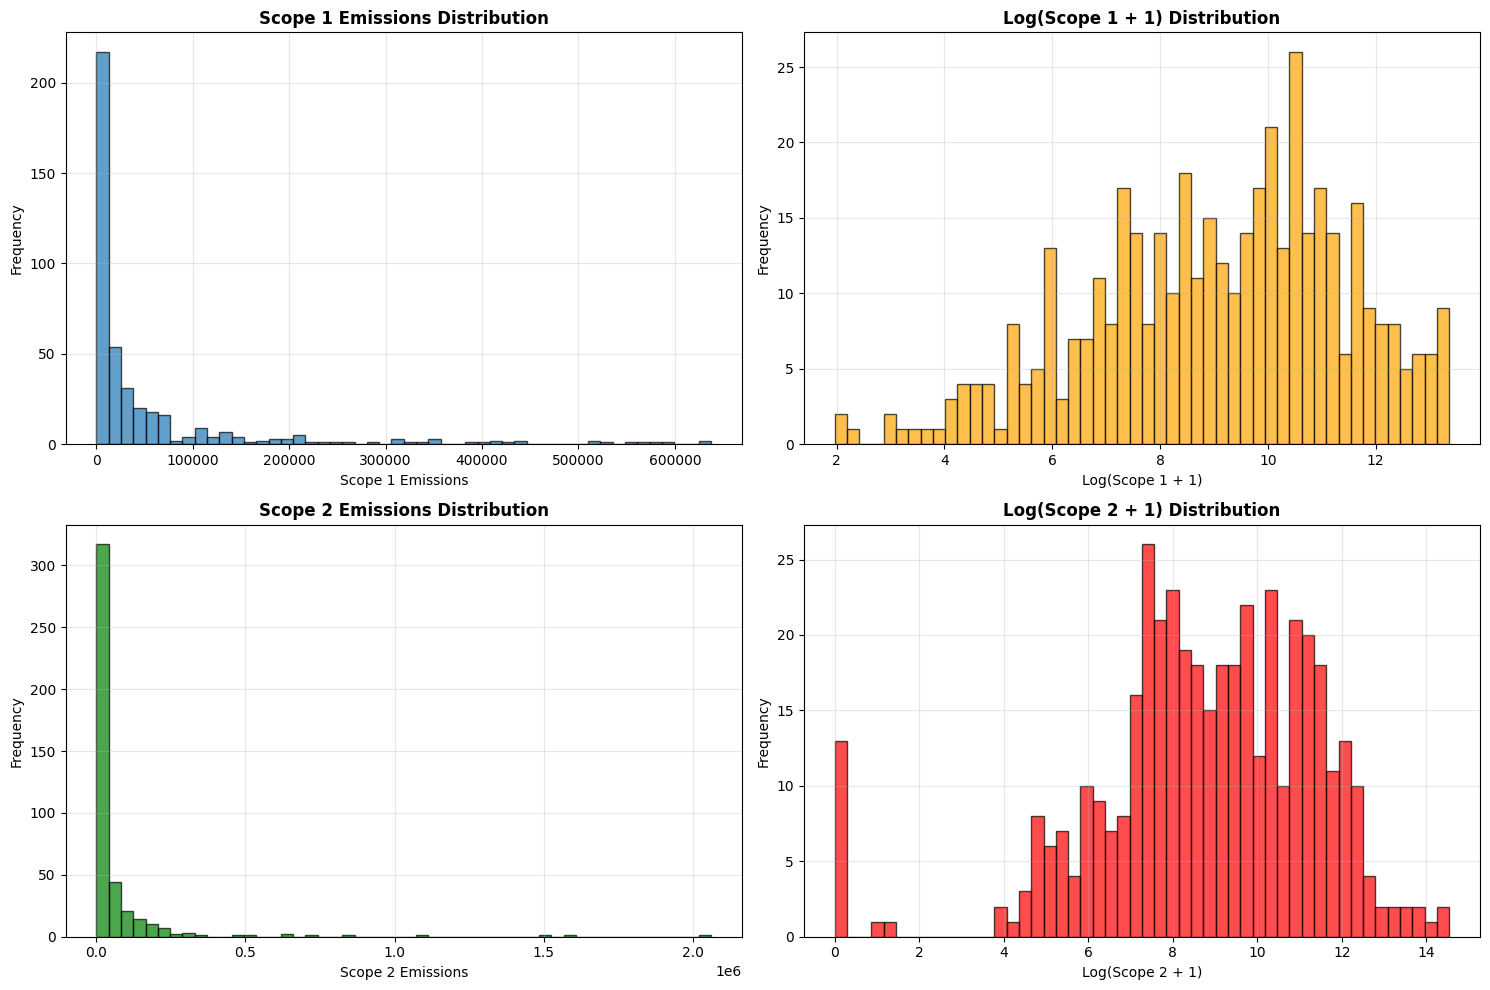


💡 Insight: Log transformation makes distributions more normal, which can help models learn better.


In [11]:
# Visualize target distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scope 1 histogram
axes[0, 0].hist(train['target_scope_1'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Scope 1 Emissions Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Scope 1 Emissions')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Scope 1 log histogram
axes[0, 1].hist(np.log1p(train['target_scope_1']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Log(Scope 1 + 1) Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log(Scope 1 + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Scope 2 histogram
axes[1, 0].hist(train['target_scope_2'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Scope 2 Emissions Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Scope 2 Emissions')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Scope 2 log histogram
axes[1, 1].hist(np.log1p(train['target_scope_2']), bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Log(Scope 2 + 1) Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Log(Scope 2 + 1)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Log transformation makes distributions more normal, which can help models learn better.")


In [12]:
# Check correlation between targets and with revenue
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

correlation_matrix = train[['target_scope_1', 'target_scope_2', 'revenue']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

scope1_scope2_corr = train['target_scope_1'].corr(train['target_scope_2'])
scope1_revenue_corr = train['target_scope_1'].corr(train['revenue'])
scope2_revenue_corr = train['target_scope_2'].corr(train['revenue'])

print(f"\n📊 Key Correlations:")
print(f"  Scope 1 vs Scope 2: {scope1_scope2_corr:.3f}")
print(f"  Scope 1 vs Revenue: {scope1_revenue_corr:.3f}")
print(f"  Scope 2 vs Revenue: {scope2_revenue_corr:.3f}")

print("\n💡 Insight: Positive correlations are expected - larger companies and higher Scope 1 emissions tend to correlate with higher Scope 2 emissions.")


CORRELATION ANALYSIS

Correlation Matrix:
                target_scope_1  target_scope_2  revenue
target_scope_1            1.00            0.53     0.19
target_scope_2            0.53            1.00     0.19
revenue                   0.19            0.19     1.00

📊 Key Correlations:
  Scope 1 vs Scope 2: 0.526
  Scope 1 vs Revenue: 0.189
  Scope 2 vs Revenue: 0.187

💡 Insight: Positive correlations are expected - larger companies and higher Scope 1 emissions tend to correlate with higher Scope 2 emissions.


### Step 1.3: Explore Relational Tables

**What we're doing:** Analyze the 1-to-many tables (sector, environmental activities, SDGs)

**Why:**
- Understand how many sectors/activities/SDGs each company typically has
- Identify sparse relationships (many companies might have no environmental activities)
- Check data quality (do revenue percentages sum to ~100% per company?)
- Understand sector distribution (which sectors are most common?)
- Identify potential feature engineering opportunities


In [13]:
# Analyze sector distribution table
print("=" * 60)
print("SECTOR DISTRIBUTION TABLE ANALYSIS")
print("=" * 60)

print(f"\nTotal rows in sector table: {len(sector)}")
print(f"Unique companies: {sector['entity_id'].nunique()}")

# Count sectors per company
sectors_per_company = sector.groupby('entity_id').size()
print(f"\n📊 Sectors per company:")
print(sectors_per_company.describe())
print(f"\nCompanies with 1 sector: {(sectors_per_company == 1).sum()}")
print(f"Companies with 2-3 sectors: {((sectors_per_company >= 2) & (sectors_per_company <= 3)).sum()}")
print(f"Companies with 4+ sectors: {(sectors_per_company >= 4).sum()}")

# Check revenue percentage sums
revenue_sums = sector.groupby('entity_id')['revenue_pct'].sum()
print(f"\n📊 Revenue percentage sums per company:")
print(revenue_sums.describe())
print(f"\nCompanies where revenue_pct sums to 100% (±1%): {((revenue_sums >= 99) & (revenue_sums <= 101)).sum()}")
print(f"Companies with revenue_pct < 99%: {(revenue_sums < 99).sum()}")
print(f"Companies with revenue_pct > 101%: {(revenue_sums > 101).sum()}")

if ((revenue_sums >= 99) & (revenue_sums <= 101)).sum() / len(revenue_sums) > 0.95:
    print("✅ Most companies have revenue percentages summing to ~100%")
else:
    print("⚠️  Many companies have revenue percentages that don't sum to 100% - investigate!")


SECTOR DISTRIBUTION TABLE ANALYSIS

Total rows in sector table: 799
Unique companies: 478

📊 Sectors per company:
count   478.00
mean      1.67
std       0.97
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       7.00
dtype: float64

Companies with 1 sector: 272
Companies with 2-3 sectors: 181
Companies with 4+ sectors: 25

📊 Revenue percentage sums per company:
count   478.00
mean      1.00
std       0.00
min       1.00
25%       1.00
50%       1.00
75%       1.00
max       1.00
Name: revenue_pct, dtype: float64

Companies where revenue_pct sums to 100% (±1%): 0
Companies with revenue_pct < 99%: 478
Companies with revenue_pct > 101%: 0
⚠️  Many companies have revenue percentages that don't sum to 100% - investigate!


In [14]:
# Analyze most common sectors
print("\n📊 Most common NACE Level 1 sectors:")
level1_counts = sector['nace_level_1_code'].value_counts()
print(level1_counts)

print("\n📊 Most common NACE Level 2 sectors (top 10):")
level2_counts = sector['nace_level_2_code'].value_counts().head(10)
print(level2_counts)

# Check if all companies in train/test have sector data
train_entities = set(train['entity_id'])
test_entities = set(test['entity_id'])
sector_entities = set(sector['entity_id'])

train_with_sector = len(train_entities & sector_entities)
test_with_sector = len(test_entities & sector_entities)

print(f"\n📊 Sector data coverage:")
print(f"Train companies with sector data: {train_with_sector}/{len(train_entities)} ({train_with_sector/len(train_entities)*100:.1f}%)")
print(f"Test companies with sector data: {test_with_sector}/{len(test_entities)} ({test_with_sector/len(test_entities)*100:.1f}%)")



📊 Most common NACE Level 1 sectors:
nace_level_1_code
C    303
J    126
G     66
M     58
N     43
H     31
K     27
F     25
R     22
I     19
Q     17
E     13
D     10
P      9
L      9
A      8
B      6
O      4
S      2
T      1
Name: count, dtype: int64

📊 Most common NACE Level 2 sectors (top 10):
nace_level_2_code
58    48
20    45
21    33
47    32
46    32
32    30
61    29
62    26
28    23
70    22
Name: count, dtype: int64

📊 Sector data coverage:
Train companies with sector data: 429/429 (100.0%)
Test companies with sector data: 49/49 (100.0%)


In [15]:
# Analyze environmental activities table
print("=" * 60)
print("ENVIRONMENTAL ACTIVITIES TABLE ANALYSIS")
print("=" * 60)

print(f"\nTotal rows in environmental table: {len(environmental)}")
print(f"Unique companies: {environmental['entity_id'].nunique()}")

# Count activities per company
activities_per_company = environmental.groupby('entity_id').size()
print(f"\n📊 Environmental activities per company:")
print(activities_per_company.describe())

# Check how many companies have NO environmental activities
all_entities = set(train['entity_id']) | set(test['entity_id'])
entities_with_activities = set(environmental['entity_id'])
entities_without_activities = len(all_entities) - len(entities_with_activities)

print(f"\nCompanies with environmental activities: {len(entities_with_activities)}")
print(f"Companies WITHOUT environmental activities: {entities_without_activities}")
print(f"Coverage: {len(entities_with_activities)/len(all_entities)*100:.1f}%")

# Analyze env_score_adjustment
print(f"\n📊 Environmental score adjustment statistics:")
print(environmental['env_score_adjustment'].describe())
print(f"\nNegative adjustments (positive activities): {(environmental['env_score_adjustment'] < 0).sum()}")
print(f"Positive adjustments (negative activities): {(environmental['env_score_adjustment'] > 0).sum()}")

# Most common activity types
print(f"\n📊 Most common activity types:")
print(environmental['activity_type'].value_counts().head(10))


ENVIRONMENTAL ACTIVITIES TABLE ANALYSIS

Total rows in environmental table: 355
Unique companies: 260

📊 Environmental activities per company:
count   260.00
mean      1.37
std       0.73
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       8.00
dtype: float64

Companies with environmental activities: 260
Companies WITHOUT environmental activities: 218
Coverage: 54.4%

📊 Environmental score adjustment statistics:
count   355.00
mean     -0.13
std       0.23
min      -1.50
25%      -0.21
50%      -0.10
75%      -0.03
max       0.50
Name: env_score_adjustment, dtype: float64

Negative adjustments (positive activities): 277
Positive adjustments (negative activities): 78

📊 Most common activity types:
activity_type
Operation         133
Other              65
Manufacturing      43
Raw materials      39
End-use            32
Disposal           16
Farming            15
Transportation     12
Name: count, dtype: int64


In [16]:
# Analyze SDG table
print("=" * 60)
print("SUSTAINABLE DEVELOPMENT GOALS TABLE ANALYSIS")
print("=" * 60)

print(f"\nTotal rows in SDG table: {len(sdg)}")
print(f"Unique companies: {sdg['entity_id'].nunique()}")

# Count SDGs per company
sdgs_per_company = sdg.groupby('entity_id').size()
print(f"\n📊 SDGs per company:")
print(sdgs_per_company.describe())

# Check how many companies have NO SDG commitments
entities_with_sdg = set(sdg['entity_id'])
entities_without_sdg = len(all_entities) - len(entities_with_sdg)

print(f"\nCompanies with SDG commitments: {len(entities_with_sdg)}")
print(f"Companies WITHOUT SDG commitments: {entities_without_sdg}")
print(f"Coverage: {len(entities_with_sdg)/len(all_entities)*100:.1f}%")

# Most common SDGs
print(f"\n📊 Most common SDGs:")
sdg_counts = sdg['sdg_id'].value_counts().sort_index()
print(sdg_counts)

# Check SDG ID range (should be 1-17)
print(f"\nSDG ID range: {sdg['sdg_id'].min()} to {sdg['sdg_id'].max()}")
if sdg['sdg_id'].min() >= 1 and sdg['sdg_id'].max() <= 17:
    print("✅ All SDG IDs are in valid range (1-17)")
else:
    print("⚠️  Found SDG IDs outside valid range!")


SUSTAINABLE DEVELOPMENT GOALS TABLE ANALYSIS

Total rows in SDG table: 165
Unique companies: 130

📊 SDGs per company:
count   130.00
mean      1.27
std       0.54
min       1.00
25%       1.00
50%       1.00
75%       1.00
max       3.00
dtype: float64

Companies with SDG commitments: 130
Companies WITHOUT SDG commitments: 348
Coverage: 27.2%

📊 Most common SDGs:
sdg_id
2      5
3     55
4     10
5      1
6      3
7     13
8      4
9     39
11    14
12    13
13     5
16     3
Name: count, dtype: int64

SDG ID range: 2 to 16
✅ All SDG IDs are in valid range (1-17)


## Phase 1 Summary

**Key Findings:**
1. ✅ **Excellent data quality** - No missing values, no duplicates, all entity_ids unique
2. ✅ **No data leakage** - Zero overlap between train and test
3. ⚠️ **Highly skewed targets** - Scope 1 (skewness: 3.15), Scope 2 (skewness: 7.34) → **Log transformation needed**
4. ✅ **Sparse relational tables** - Environmental activities and SDGs are sparse (expected)
5. ✅ **All test regions exist in training** - No cold start problem
6. ✅ **Ready for feature engineering** - Clean data structure

**Key Insights:**
- Both target variables are highly right-skewed → log transformation will significantly help models
- 13 companies (3%) have zero Scope 2 emissions (legitimate - may not purchase electricity)
- Sector data is rich and will be a strong predictor
- Geographic distribution is balanced (WEU and NAM dominate)

**Next Steps:** Proceed to Phase 2: Data Quality & Preprocessing (quick validation), then Phase 3: Feature Engineering

---

## Phase 2: Data Quality & Preprocessing

**Note:** Phase 1 revealed excellent data quality with no missing values. Phase 2 will perform final validation checks before feature engineering.

### Step 2.1: Final Data Quality Validation

**What we're doing:** Final checks to ensure data is ready for feature engineering

**Why:**
- Double-check everything before transformations
- Ensure train and test distributions are similar
- Verify no issues that could cause problems later


In [17]:
# Final validation: Compare train and test distributions
print("=" * 60)
print("PHASE 2: FINAL DATA QUALITY VALIDATION")
print("=" * 60)

print("\n📊 Train vs Test Distribution Comparison:")
print(f"\nRevenue statistics:")
print(f"  Train - Mean: {train['revenue'].mean():.2f}, Median: {train['revenue'].median():.2f}")
print(f"  Test  - Mean: {test['revenue'].mean():.2f}, Median: {test['revenue'].median():.2f}")

print(f"\nSustainability scores (train vs test):")
for score in ['overall_score', 'environmental_score', 'social_score', 'governance_score']:
    train_mean = train[score].mean()
    test_mean = test[score].mean()
    diff = abs(train_mean - test_mean)
    status = "✅" if diff < 0.5 else "⚠️"
    print(f"  {score}: Train={train_mean:.2f}, Test={test_mean:.2f}, Diff={diff:.2f} {status}")

print("\n✅ Phase 2 Complete: Data quality validated, ready for feature engineering!")


PHASE 2: FINAL DATA QUALITY VALIDATION

📊 Train vs Test Distribution Comparison:

Revenue statistics:
  Train - Mean: 4628382624.68, Median: 1655100000.00
  Test  - Mean: 3773821816.33, Median: 1605096000.00

Sustainability scores (train vs test):
  overall_score: Train=2.99, Test=3.05, Diff=0.06 ✅
  environmental_score: Train=3.46, Test=3.60, Diff=0.15 ✅
  social_score: Train=2.80, Test=2.88, Diff=0.08 ✅
  governance_score: Train=2.38, Test=2.27, Diff=0.11 ✅

✅ Phase 2 Complete: Data quality validated, ready for feature engineering!


---

## Phase 3: Feature Engineering

This is the **most important phase** - creating meaningful features from the raw data.

### Step 3.1: Geographic Features

**What we're doing:** Encode geographic information (region, country)

**Why:**
- Different regions have different energy grid carbon intensity (affects Scope 2)
- Different environmental regulations (affects both scopes)
- One-hot encoding allows models to learn region-specific patterns


In [18]:
# Create copies for feature engineering (preserve originals)
train_fe = train.copy()
test_fe = test.copy()

print("=" * 60)
print("PHASE 3: FEATURE ENGINEERING")
print("=" * 60)
print("\nStarting with {len(train_fe)} train and {len(test_fe)} test companies")

# Step 3.1: Geographic Features - One-hot encode region_code
print("\n" + "=" * 60)
print("Step 3.1: Geographic Features")
print("=" * 60)

# One-hot encode region_code
train_fe = pd.get_dummies(train_fe, columns=['region_code'], prefix='region')
test_fe = pd.get_dummies(test_fe, columns=['region_code'], prefix='region')

# Ensure test has same region columns as train (add missing with 0s)
for col in train_fe.columns:
    if col.startswith('region_') and col not in test_fe.columns:
        test_fe[col] = 0

# Ensure train has same region columns as test (add missing with 0s)
for col in test_fe.columns:
    if col.startswith('region_') and col not in train_fe.columns:
        train_fe[col] = 0

# Reorder columns to match
region_cols = sorted([col for col in train_fe.columns if col.startswith('region_')])
print(f"\n✅ Created {len(region_cols)} region features:")
print(f"   {region_cols}")

print(f"\nTrain shape: {train_fe.shape}")
print(f"Test shape: {test_fe.shape}")


PHASE 3: FEATURE ENGINEERING

Starting with {len(train_fe)} train and {len(test_fe)} test companies

Step 3.1: Geographic Features

✅ Created 8 region features:
   ['region_ANZ', 'region_CAR', 'region_EA', 'region_EEU', 'region_LATAM', 'region_NAM', 'region_WEU', 'region_name']

Train shape: (429, 18)
Test shape: (49, 16)


### Step 3.2: Sector Distribution Features (NACE Level 1)

**What we're doing:** Aggregate sector revenue percentages to entity level

**Why:**
- Different sectors have vastly different emission intensities
- Manufacturing (high Scope 1) vs Services (low Scope 1, moderate Scope 2)
- Revenue percentage indicates how much of company's operations are in each sector
- Pivoting creates one row per company with sector exposure percentages


In [19]:
# Step 3.2: Sector Features - NACE Level 1
print("\n" + "=" * 60)
print("Step 3.2: Sector Distribution Features (NACE Level 1)")
print("=" * 60)

# Pivot sector data to entity level
level_1_sect = sector.pivot_table(
    values='revenue_pct',
    index='entity_id',
    columns='nace_level_1_code',
    aggfunc='sum',
    fill_value=0
).add_prefix('sect_').add_suffix('_pct').reset_index()

print(f"\nCreated sector features for {len(level_1_sect)} companies")
print(f"Sector columns: {list(level_1_sect.columns[1:])}")  # Exclude entity_id

# Join to train and test
train_fe = train_fe.merge(level_1_sect, on='entity_id', how='left')
test_fe = test_fe.merge(level_1_sect, on='entity_id', how='left')

# Fill missing sector percentages with 0 (company has 0% in that sector)
sect_cols = [col for col in level_1_sect.columns if col != 'entity_id']
train_fe[sect_cols] = train_fe[sect_cols].fillna(0)
test_fe[sect_cols] = test_fe[sect_cols].fillna(0)

print(f"\n✅ Created {len(sect_cols)} sector features")
print(f"Train shape: {train_fe.shape}")
print(f"Test shape: {test_fe.shape}")

# Validation: Check revenue percentages sum to ~100%
revenue_sums = train_fe[sect_cols].sum(axis=1)
print(f"\n📊 Revenue percentage validation:")
print(f"  Mean sum: {revenue_sums.mean():.1f}%")
print(f"  Companies with sum 99-101%: {((revenue_sums >= 99) & (revenue_sums <= 101)).sum()}/{len(train_fe)}")



Step 3.2: Sector Distribution Features (NACE Level 1)

Created sector features for 478 companies
Sector columns: ['sect_A_pct', 'sect_B_pct', 'sect_C_pct', 'sect_D_pct', 'sect_E_pct', 'sect_F_pct', 'sect_G_pct', 'sect_H_pct', 'sect_I_pct', 'sect_J_pct', 'sect_K_pct', 'sect_L_pct', 'sect_M_pct', 'sect_N_pct', 'sect_O_pct', 'sect_P_pct', 'sect_Q_pct', 'sect_R_pct', 'sect_S_pct', 'sect_T_pct']

✅ Created 20 sector features
Train shape: (429, 38)
Test shape: (49, 36)

📊 Revenue percentage validation:
  Mean sum: 1.0%
  Companies with sum 99-101%: 0/429


### Step 3.3: Sector Diversity Features

**What we're doing:** Create metrics describing how diversified a company's sector exposure is

**Why:**
- Diversified companies might have different emission profiles than focused ones
- Sector concentration (Herfindahl index) measures diversification
- Number of sectors indicates complexity


In [20]:
# Step 3.3: Sector Diversity Features
print("\n" + "=" * 60)
print("Step 3.3: Sector Diversity Features")
print("=" * 60)

# Count number of sectors per company (revenue_pct > 0)
train_fe['num_sectors'] = (train_fe[sect_cols] > 0).sum(axis=1)
test_fe['num_sectors'] = (test_fe[sect_cols] > 0).sum(axis=1)

# Calculate Herfindahl-Hirschman Index (HHI) for sector concentration
# HHI = sum of squared revenue percentages (0-1 scale, higher = more concentrated)
train_fe['sector_hhi'] = (train_fe[sect_cols] / 100).pow(2).sum(axis=1)
test_fe['sector_hhi'] = (test_fe[sect_cols] / 100).pow(2).sum(axis=1)

# Find dominant sector (highest revenue percentage)
train_fe['dominant_sector_pct'] = train_fe[sect_cols].max(axis=1)
test_fe['dominant_sector_pct'] = test_fe[sect_cols].max(axis=1)

# Binary: is company diversified (more than 1 sector)
train_fe['is_diversified'] = (train_fe['num_sectors'] > 1).astype(int)
test_fe['is_diversified'] = (test_fe['num_sectors'] > 1).astype(int)

print(f"\n✅ Created sector diversity features:")
print(f"   - num_sectors: Number of sectors per company")
print(f"   - sector_hhi: Herfindahl-Hirschman Index (concentration)")
print(f"   - dominant_sector_pct: Percentage of revenue from dominant sector")
print(f"   - is_diversified: Binary indicator (1 if >1 sector)")

print(f"\nSector diversity statistics:")
print(f"  Mean sectors per company: {train_fe['num_sectors'].mean():.2f}")
print(f"  Diversified companies: {train_fe['is_diversified'].sum()}/{len(train_fe)} ({train_fe['is_diversified'].mean()*100:.1f}%)")



Step 3.3: Sector Diversity Features

✅ Created sector diversity features:
   - num_sectors: Number of sectors per company
   - sector_hhi: Herfindahl-Hirschman Index (concentration)
   - dominant_sector_pct: Percentage of revenue from dominant sector
   - is_diversified: Binary indicator (1 if >1 sector)

Sector diversity statistics:
  Mean sectors per company: 1.37
  Diversified companies: 123/429 (28.7%)


### Step 3.4: Environmental Activity Features

**What we're doing:** Aggregate environmental activity data to entity level

**Why:**
- Environmental activities indicate company's environmental focus
- Positive activities (negative env_score_adjustment) might correlate with lower emissions
- Sum of adjustments gives overall environmental impact score
- Count of activities indicates engagement level


In [21]:
# Step 3.4: Environmental Activity Features
print("\n" + "=" * 60)
print("Step 3.4: Environmental Activity Features")
print("=" * 60)

# Aggregate environmental activities
env_features = environmental.groupby('entity_id').agg({
    'env_score_adjustment': ['sum', 'count']
}).reset_index()
env_features.columns = ['entity_id', 'env_score_adjustment_sum', 'num_env_activities']

# Separate positive and negative adjustments
env_pos = environmental[environmental['env_score_adjustment'] > 0].groupby('entity_id')['env_score_adjustment'].sum().reset_index()
env_pos.columns = ['entity_id', 'env_positive_adjustment']
env_neg = environmental[environmental['env_score_adjustment'] < 0].groupby('entity_id')['env_score_adjustment'].sum().reset_index()
env_neg.columns = ['entity_id', 'env_negative_adjustment']

# Join all environmental features
env_features = env_features.merge(env_pos, on='entity_id', how='left')
env_features = env_features.merge(env_neg, on='entity_id', how='left')

# Join to train and test (left join to preserve all companies)
train_fe = train_fe.merge(env_features, on='entity_id', how='left')
test_fe = test_fe.merge(env_features, on='entity_id', how='left')

# Fill missing with 0 (no environmental activities)
env_cols = ['env_score_adjustment_sum', 'num_env_activities', 'env_positive_adjustment', 'env_negative_adjustment']
train_fe[env_cols] = train_fe[env_cols].fillna(0)
test_fe[env_cols] = test_fe[env_cols].fillna(0)

# Create binary indicator
train_fe['has_env_activities'] = (train_fe['num_env_activities'] > 0).astype(int)
test_fe['has_env_activities'] = (test_fe['num_env_activities'] > 0).astype(int)

print(f"\n✅ Created environmental activity features:")
print(f"   - env_score_adjustment_sum: Total environmental score adjustment")
print(f"   - num_env_activities: Count of environmental activities")
print(f"   - env_positive_adjustment: Sum of positive adjustments (bad activities)")
print(f"   - env_negative_adjustment: Sum of negative adjustments (good activities)")
print(f"   - has_env_activities: Binary indicator")

print(f"\nEnvironmental activity statistics:")
print(f"  Companies with activities: {train_fe['has_env_activities'].sum()}/{len(train_fe)} ({train_fe['has_env_activities'].mean()*100:.1f}%)")
print(f"  Mean activities per company: {train_fe['num_env_activities'].mean():.2f}")



Step 3.4: Environmental Activity Features

✅ Created environmental activity features:
   - env_score_adjustment_sum: Total environmental score adjustment
   - num_env_activities: Count of environmental activities
   - env_positive_adjustment: Sum of positive adjustments (bad activities)
   - env_negative_adjustment: Sum of negative adjustments (good activities)
   - has_env_activities: Binary indicator

Environmental activity statistics:
  Companies with activities: 237/429 (55.2%)
  Mean activities per company: 0.76


### Step 3.5: SDG Commitment Features

**What we're doing:** Encode SDG commitments as features

**Why:**
- SDG commitments indicate sustainability focus
- Different SDGs relate differently to emissions (SDG 7, 13 are directly related)
- Count of SDGs indicates commitment level
- Presence/absence of specific SDGs might be predictive


In [22]:
# Step 3.5: SDG Commitment Features
print("\n" + "=" * 60)
print("Step 3.5: SDG Commitment Features")
print("=" * 60)

# One-hot encode SDG IDs
sdg_encoded = pd.get_dummies(sdg[['entity_id', 'sdg_id']], columns=['sdg_id'], prefix='sdg')
sdg_encoded = sdg_encoded.groupby('entity_id').sum().reset_index()

# Count total SDGs per company
sdg_count = sdg.groupby('entity_id').size().reset_index(name='num_sdgs')

# Create specific SDG indicators (SDG 7: Clean Energy, SDG 13: Climate Action)
sdg_7_13 = sdg[sdg['sdg_id'].isin([7, 13])].groupby('entity_id')['sdg_id'].apply(lambda x: 1 if 7 in x.values else (2 if 13 in x.values else 0)).reset_index()
sdg_7_13.columns = ['entity_id', 'has_sdg_7_or_13']
sdg_7_13['has_sdg_7_or_13'] = (sdg_7_13['has_sdg_7_or_13'] > 0).astype(int)

# Combine SDG features
sdg_features = sdg_encoded.merge(sdg_count, on='entity_id', how='left')
sdg_features = sdg_features.merge(sdg_7_13, on='entity_id', how='left')
sdg_features['num_sdgs'] = sdg_features['num_sdgs'].fillna(0)
sdg_features['has_sdg_7_or_13'] = sdg_features['has_sdg_7_or_13'].fillna(0)

# Join to train and test (left join)
train_fe = train_fe.merge(sdg_features, on='entity_id', how='left')
test_fe = test_fe.merge(sdg_features, on='entity_id', how='left')

# Fill missing SDG columns with 0
sdg_cols = [col for col in sdg_features.columns if col != 'entity_id']
train_fe[sdg_cols] = train_fe[sdg_cols].fillna(0)
test_fe[sdg_cols] = test_fe[sdg_cols].fillna(0)

# Ensure test has same SDG columns as train
for col in train_fe.columns:
    if col.startswith('sdg_') and col not in test_fe.columns:
        test_fe[col] = 0

# Create binary indicator
train_fe['has_sdgs'] = (train_fe['num_sdgs'] > 0).astype(int)
test_fe['has_sdgs'] = (test_fe['num_sdgs'] > 0).astype(int)

print(f"\n✅ Created SDG commitment features:")
print(f"   - num_sdgs: Total number of SDG commitments")
print(f"   - has_sdg_7_or_13: Binary for SDG 7 (Clean Energy) or SDG 13 (Climate Action)")
print(f"   - has_sdgs: Binary indicator for any SDG commitment")
print(f"   - sdg_X: One-hot encoded SDG IDs")

print(f"\nSDG commitment statistics:")
print(f"  Companies with SDGs: {train_fe['has_sdgs'].sum()}/{len(train_fe)} ({train_fe['has_sdgs'].mean()*100:.1f}%)")
print(f"  Mean SDGs per company: {train_fe['num_sdgs'].mean():.2f}")
print(f"  Companies with SDG 7 or 13: {train_fe['has_sdg_7_or_13'].sum()}/{len(train_fe)}")



Step 3.5: SDG Commitment Features

✅ Created SDG commitment features:
   - num_sdgs: Total number of SDG commitments
   - has_sdg_7_or_13: Binary for SDG 7 (Clean Energy) or SDG 13 (Climate Action)
   - has_sdgs: Binary indicator for any SDG commitment
   - sdg_X: One-hot encoded SDG IDs

SDG commitment statistics:
  Companies with SDGs: 118/429 (27.5%)
  Mean SDGs per company: 0.35
  Companies with SDG 7 or 13: 15.0/429


### Step 3.6: Revenue-Based Features

**What we're doing:** Create features derived from revenue

**Why:**
- Revenue is a strong proxy for company size
- Larger companies typically have higher absolute emissions
- But emissions per revenue unit (intensity) varies by sector
- Log transformation helps with skewed distribution


In [23]:
# Step 3.6: Revenue-Based Features
print("\n" + "=" * 60)
print("Step 3.6: Revenue-Based Features")
print("=" * 60)

# Log transform revenue (handle skewed distribution)
train_fe['log_revenue'] = np.log1p(train_fe['revenue'])  # log1p = log(1+x) handles zeros
test_fe['log_revenue'] = np.log1p(test_fe['revenue'])

# Revenue categories (optional - for non-linear relationships)
train_fe['revenue_category'] = pd.cut(train_fe['revenue'], 
                                      bins=[0, 1e8, 1e9, 1e10, np.inf],
                                      labels=['Small', 'Medium', 'Large', 'Very Large'])
test_fe['revenue_category'] = pd.cut(test_fe['revenue'],
                                     bins=[0, 1e8, 1e9, 1e10, np.inf],
                                     labels=['Small', 'Medium', 'Large', 'Very Large'])

# One-hot encode revenue category
train_fe = pd.get_dummies(train_fe, columns=['revenue_category'], prefix='revenue_cat')
test_fe = pd.get_dummies(test_fe, columns=['revenue_category'], prefix='revenue_cat')

# Ensure test has same revenue category columns
for col in train_fe.columns:
    if col.startswith('revenue_cat_') and col not in test_fe.columns:
        test_fe[col] = 0

print(f"\n✅ Created revenue-based features:")
print(f"   - log_revenue: Log-transformed revenue (handles skewness)")
print(f"   - revenue_cat_X: Revenue category (Small, Medium, Large, Very Large)")

print(f"\nRevenue statistics:")
print(f"  Original revenue - Mean: {train_fe['revenue'].mean():.2e}, Median: {train_fe['revenue'].median():.2e}")
print(f"  Log revenue - Mean: {train_fe['log_revenue'].mean():.2f}, Median: {train_fe['log_revenue'].median():.2f}")



Step 3.6: Revenue-Based Features

✅ Created revenue-based features:
   - log_revenue: Log-transformed revenue (handles skewness)
   - revenue_cat_X: Revenue category (Small, Medium, Large, Very Large)

Revenue statistics:
  Original revenue - Mean: 4.63e+09, Median: 1.66e+09
  Log revenue - Mean: 21.38, Median: 21.23


### Step 3.7: Interaction Features

**What we're doing:** Create features that combine multiple base features

**Why:**
- Interactions capture complex relationships
- Revenue × sector: different sectors scale differently with size
- Region × sector: same sector might have different emissions in different regions
- Score × revenue: environmental focus might matter more for larger companies


In [24]:
# Step 3.7: Interaction Features
print("\n" + "=" * 60)
print("Step 3.7: Interaction Features")
print("=" * 60)

# Revenue × dominant sector percentage
train_fe['revenue_x_dominant_sector'] = train_fe['revenue'] * train_fe['dominant_sector_pct'] / 100
test_fe['revenue_x_dominant_sector'] = test_fe['revenue'] * test_fe['dominant_sector_pct'] / 100

# Revenue × environmental score
train_fe['revenue_x_env_score'] = train_fe['revenue'] * train_fe['environmental_score']
test_fe['revenue_x_env_score'] = test_fe['revenue'] * test_fe['environmental_score']

# Log revenue × environmental score
train_fe['log_revenue_x_env_score'] = train_fe['log_revenue'] * train_fe['environmental_score']
test_fe['log_revenue_x_env_score'] = test_fe['log_revenue'] * test_fe['environmental_score']

# Revenue × sector diversity
train_fe['revenue_x_diversity'] = train_fe['revenue'] * train_fe['num_sectors']
test_fe['revenue_x_diversity'] = test_fe['revenue'] * test_fe['num_sectors']

print(f"\n✅ Created interaction features:")
print(f"   - revenue_x_dominant_sector: Revenue × dominant sector percentage")
print(f"   - revenue_x_env_score: Revenue × environmental score")
print(f"   - log_revenue_x_env_score: Log revenue × environmental score")
print(f"   - revenue_x_diversity: Revenue × number of sectors")

print(f"\nFeature engineering complete!")
print(f"Final train shape: {train_fe.shape}")
print(f"Final test shape: {test_fe.shape}")



Step 3.7: Interaction Features

✅ Created interaction features:
   - revenue_x_dominant_sector: Revenue × dominant sector percentage
   - revenue_x_env_score: Revenue × environmental score
   - log_revenue_x_env_score: Log revenue × environmental score
   - revenue_x_diversity: Revenue × number of sectors

Feature engineering complete!
Final train shape: (429, 71)
Final test shape: (49, 69)


### Step 3.8: Feature Selection

**What we're doing:** Remove low-variance or uninformative features

**Why:**
- Too many features can lead to overfitting
- Low-variance features provide little information
- Reduces model complexity and training time
- Improves generalization


In [25]:
# Step 3.8: Feature Selection
print("\n" + "=" * 60)
print("Step 3.8: Feature Selection")
print("=" * 60)

from sklearn.feature_selection import VarianceThreshold

# Exclude non-feature columns
cols_to_exclude = ['entity_id', 'region_name', 'country_name', 'country_code', 
                   'target_scope_1', 'target_scope_2']
feature_cols = [col for col in train_fe.columns if col not in cols_to_exclude]

# Apply variance threshold (remove near-constant features)
feature_selector = VarianceThreshold(threshold=0.01)  # Keep features with variance > 0.01
feature_selector.fit(train_fe[feature_cols])

selected_features = feature_selector.get_feature_names_out().tolist()
removed_features = [col for col in feature_cols if col not in selected_features]

print(f"\n📊 Feature selection results:")
print(f"  Original features: {len(feature_cols)}")
print(f"  Selected features: {len(selected_features)}")
print(f"  Removed features: {len(removed_features)}")

if removed_features:
    print(f"\n  Removed features: {removed_features[:10]}...")  # Show first 10

# Create final datasets with selected features
final_train = train_fe[selected_features + ['entity_id', 'target_scope_1', 'target_scope_2']].copy()
final_test = test_fe[selected_features + ['entity_id']].copy()

print(f"\n✅ Final datasets created:")
print(f"  Train: {final_train.shape}")
print(f"  Test: {final_test.shape}")

# Save for next phase
import os
save_dir = 'notebooks' if os.path.exists('notebooks') else '.'
final_train.to_pickle(f'{save_dir}/final_train_fe.pkl')
final_test.to_pickle(f'{save_dir}/final_test_fe.pkl')

print(f"\n✅ Feature engineering complete! Datasets saved.")
print(f"   Ready for Phase 4: Model Development")



Step 3.8: Feature Selection



📊 Feature selection results:
  Original features: 65
  Selected features: 46
  Removed features: 19

  Removed features: ['region_ANZ', 'region_CAR', 'region_EA', 'region_EEU', 'region_LATAM', 'sect_A_pct', 'sect_B_pct', 'sect_D_pct', 'sect_E_pct', 'sect_O_pct']...

✅ Final datasets created:
  Train: (429, 49)
  Test: (49, 47)

✅ Feature engineering complete! Datasets saved.
   Ready for Phase 4: Model Development


---

## Phase 4: Model Development

This phase will train and evaluate models to predict Scope 1 and Scope 2 emissions.

### Step 4.1: Prepare Training Data

**What we're doing:** Load feature-engineered data and prepare for modeling

**Why:**
- Separate features (X) from targets (y)
- Apply log transformation to targets (they're highly skewed)
- Ensure train and test have same features
- Final validation before training


In [26]:
# Step 4.1: Prepare Training Data
print("=" * 60)
print("PHASE 4: MODEL DEVELOPMENT")
print("=" * 60)

# Load feature-engineered datasets
import os
load_path = 'notebooks/final_train_fe.pkl' if os.path.exists('notebooks/final_train_fe.pkl') else 'final_train_fe.pkl'
train_model = pd.read_pickle(load_path)
test_model = pd.read_pickle(load_path.replace('train', 'test'))

print(f"\n✅ Loaded feature-engineered datasets:")
print(f"  Train: {train_model.shape}")
print(f"  Test: {test_model.shape}")

# Separate features and targets
X_train = train_model.drop(columns=['entity_id', 'target_scope_1', 'target_scope_2'])
y_scope1 = train_model['target_scope_1']
y_scope2 = train_model['target_scope_2']
X_test = test_model.drop(columns=['entity_id'])
entity_ids_test = test_model['entity_id']

print(f"\n📊 Data preparation:")
print(f"  Features (X_train): {X_train.shape}")
print(f"  Scope 1 target: {y_scope1.shape}")
print(f"  Scope 2 target: {y_scope2.shape}")
print(f"  Test features: {X_test.shape}")

# Apply log transformation to targets (they're highly skewed)
y_scope1_log = np.log1p(y_scope1)  # log1p = log(1+x) handles zeros
y_scope2_log = np.log1p(y_scope2)

print(f"\n✅ Applied log transformation to targets:")
print(f"  Scope 1 - Original skewness: {y_scope1.skew():.2f}, Log skewness: {y_scope1_log.skew():.2f}")
print(f"  Scope 2 - Original skewness: {y_scope2.skew():.2f}, Log skewness: {y_scope2_log.skew():.2f}")

# Verify no missing values
print(f"\n📊 Data quality check:")
print(f"  Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"  Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"  Infinite values in X_train: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Infinite values in targets: {np.isinf(y_scope1_log).sum() + np.isinf(y_scope2_log).sum()}")

print(f"\n✅ Data ready for model training!")


PHASE 4: MODEL DEVELOPMENT

✅ Loaded feature-engineered datasets:
  Train: (429, 49)
  Test: (49, 47)

📊 Data preparation:
  Features (X_train): (429, 46)
  Scope 1 target: (429,)
  Scope 2 target: (429,)
  Test features: (49, 46)

✅ Applied log transformation to targets:
  Scope 1 - Original skewness: 3.15, Log skewness: -0.45
  Scope 2 - Original skewness: 7.34, Log skewness: -0.99

📊 Data quality check:
  Missing values in X_train: 0
  Missing values in X_test: 0
  Infinite values in X_train: 0
  Infinite values in targets: 0

✅ Data ready for model training!


### Step 4.2: Train-Validation Split

**What we're doing:** Split training data for validation

**Why:**
- Need to evaluate model performance without using test set
- Prevents overfitting
- Allows hyperparameter tuning
- K-fold CV provides more robust performance estimate


In [27]:
# Step 4.2: Train-Validation Split
print("\n" + "=" * 60)
print("Step 4.2: Train-Validation Split")
print("=" * 60)

from sklearn.model_selection import train_test_split

# Split for validation (80/20)
X_train_split, X_val_split, y_s1_train, y_s1_val = train_test_split(
    X_train, y_scope1_log, test_size=0.2, random_state=42
)
_, _, y_s2_train, y_s2_val = train_test_split(
    X_train, y_scope2_log, test_size=0.2, random_state=42
)

print(f"\n✅ Train-validation split:")
print(f"  Training set: {X_train_split.shape[0]} samples")
print(f"  Validation set: {X_val_split.shape[0]} samples")
print(f"  Split ratio: 80/20")

print(f"\n✅ Ready for model training and validation!")



Step 4.2: Train-Validation Split

✅ Train-validation split:
  Training set: 343 samples
  Validation set: 86 samples
  Split ratio: 80/20

✅ Ready for model training and validation!


### Step 4.3: Baseline Model Training

**What we're doing:** Train simple baseline models (Linear Regression, Random Forest)

**Why:**
- Establishes performance baseline
- Linear model: fast, interpretable, good for understanding relationships
- Random Forest: handles non-linearities, feature interactions automatically
- Compare to see which approach works better


In [28]:
# Step 4.3: Baseline Model Training
print("\n" + "=" * 60)
print("Step 4.3: Baseline Model Training")
print("=" * 60)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name, target_name):
    """Evaluate model and return metrics"""
    # Convert back from log space
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    print(f"\n📊 {model_name} - {target_name} Performance:")
    print(f"  RMSE: {rmse:,.2f}")
    print(f"  MAE: {mae:,.2f}")
    print(f"  R²: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# Train Linear Regression models
print("\n🔵 Training Linear Regression models...")

# Scope 1
lr_s1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
lr_s1.fit(X_train_split, y_s1_train)
y_s1_pred_lr = lr_s1.predict(X_val_split)
lr_s1_metrics = evaluate_model(y_s1_val, y_s1_pred_lr, "Linear Regression", "Scope 1")

# Scope 2
lr_s2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
lr_s2.fit(X_train_split, y_s2_train)
y_s2_pred_lr = lr_s2.predict(X_val_split)
lr_s2_metrics = evaluate_model(y_s2_val, y_s2_pred_lr, "Linear Regression", "Scope 2")

# Train Random Forest models
print("\n🟢 Training Random Forest models...")

# Scope 1
rf_s1 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_s1.fit(X_train_split, y_s1_train)
y_s1_pred_rf = rf_s1.predict(X_val_split)
rf_s1_metrics = evaluate_model(y_s1_val, y_s1_pred_rf, "Random Forest", "Scope 1")

# Scope 2
rf_s2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_s2.fit(X_train_split, y_s2_train)
y_s2_pred_rf = rf_s2.predict(X_val_split)
rf_s2_metrics = evaluate_model(y_s2_val, y_s2_pred_rf, "Random Forest", "Scope 2")

# Train Boosting Models (Gradient Boosting - built into sklearn, no external deps)
print("\n🟡 Training Boosting Models (Gradient Boosting)...")

from sklearn.ensemble import GradientBoostingRegressor

# Scope 1
gb_s1 = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_s1.fit(X_train_split, y_s1_train)
y_s1_pred_gb = gb_s1.predict(X_val_split)
gb_s1_metrics = evaluate_model(y_s1_val, y_s1_pred_gb, "Gradient Boosting", "Scope 1")

# Scope 2
gb_s2 = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_s2.fit(X_train_split, y_s2_train)
y_s2_pred_gb = gb_s2.predict(X_val_split)
gb_s2_metrics = evaluate_model(y_s2_val, y_s2_pred_gb, "Gradient Boosting", "Scope 2")

gb_available = True
print("\n✅ Gradient Boosting models trained and evaluated!")

print("\n✅ All models trained and evaluated!")



Step 4.3: Baseline Model Training

🔵 Training Linear Regression models...

📊 Linear Regression - Scope 1 Performance:
  RMSE: 156,686.44
  MAE: 71,563.14
  R²: -0.2350

📊 Linear Regression - Scope 2 Performance:
  RMSE: 230,223.43
  MAE: 80,824.37
  R²: -0.7344

🟢 Training Random Forest models...

📊 Random Forest - Scope 1 Performance:
  RMSE: 140,272.43
  MAE: 56,927.28
  R²: 0.0102



📊 Random Forest - Scope 2 Performance:
  RMSE: 179,608.14
  MAE: 61,727.31
  R²: -0.0556

🟡 Training Boosting Models (Gradient Boosting)...

📊 Gradient Boosting - Scope 1 Performance:
  RMSE: 144,199.24
  MAE: 58,550.59
  R²: -0.0460

📊 Gradient Boosting - Scope 2 Performance:
  RMSE: 179,761.85
  MAE: 64,751.47
  R²: -0.0574

✅ Gradient Boosting models trained and evaluated!

✅ All models trained and evaluated!


### Step 4.4: Cross-Validation Evaluation

**What we're doing:** Use K-fold cross-validation for more robust performance estimates

**Why:**
- Single train/validation split can be biased
- K-fold CV gives more reliable performance estimate
- Better for comparing models
- Reduces variance in performance estimates


In [29]:
# Step 4.4: Cross-Validation Evaluation
print("\n" + "=" * 60)
print("Step 4.4: Cross-Validation Evaluation")
print("=" * 60)

from sklearn.model_selection import cross_val_score, KFold

def cv_evaluate_model(model, X, y, model_name, target_name, cv_folds=5):
    """Evaluate model using cross-validation"""
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Perform cross-validation (using negative MSE, convert to RMSE)
    cv_scores = cross_val_score(
        model, X, y, 
        cv=kfold, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Convert to RMSE (positive values)
    rmse_scores = np.sqrt(-cv_scores)
    
    print(f"\n📊 {model_name} - {target_name} (CV):")
    print(f"  RMSE scores: {rmse_scores}")
    print(f"  Mean RMSE: {rmse_scores.mean():,.2f}")
    print(f"  Std RMSE: {rmse_scores.std():,.2f}")
    
    return rmse_scores.mean(), rmse_scores.std()

# Evaluate Linear Regression with CV
print("\n🔵 Linear Regression Cross-Validation:")
lr_s1_cv_mean, lr_s1_cv_std = cv_evaluate_model(
    lr_s1, X_train, y_scope1_log, "Linear Regression", "Scope 1"
)
lr_s2_cv_mean, lr_s2_cv_std = cv_evaluate_model(
    lr_s2, X_train, y_scope2_log, "Linear Regression", "Scope 2"
)

# Evaluate Random Forest with CV
print("\n🟢 Random Forest Cross-Validation:")
rf_s1_cv_mean, rf_s1_cv_std = cv_evaluate_model(
    rf_s1, X_train, y_scope1_log, "Random Forest", "Scope 1"
)
rf_s2_cv_mean, rf_s2_cv_std = cv_evaluate_model(
    rf_s2, X_train, y_scope2_log, "Random Forest", "Scope 2"
)

# Evaluate Gradient Boosting with CV
if 'gb_available' in locals() and gb_available:
    print("\n🟡 Gradient Boosting Cross-Validation:")
    gb_s1_cv_mean, gb_s1_cv_std = cv_evaluate_model(
        gb_s1, X_train, y_scope1_log, "Gradient Boosting", "Scope 1"
    )
    gb_s2_cv_mean, gb_s2_cv_std = cv_evaluate_model(
        gb_s2, X_train, y_scope2_log, "Gradient Boosting", "Scope 2"
    )
else:
    print("\n⚠️  Gradient Boosting not available for cross-validation")
    gb_s1_cv_mean, gb_s1_cv_std = float('inf'), 0
    gb_s2_cv_mean, gb_s2_cv_std = float('inf'), 0

print("\n✅ Cross-validation complete!")



Step 4.4: Cross-Validation Evaluation

🔵 Linear Regression Cross-Validation:



📊 Linear Regression - Scope 1 (CV):
  RMSE scores: [2.61414789 1.7632874  1.90702917 2.06153629 1.8185902 ]
  Mean RMSE: 2.03
  Std RMSE: 0.31



📊 Linear Regression - Scope 2 (CV):
  RMSE scores: [2.54204457 2.60991077 2.64330308 2.56933612 2.1690086 ]
  Mean RMSE: 2.51
  Std RMSE: 0.17

🟢 Random Forest Cross-Validation:



📊 Random Forest - Scope 1 (CV):
  RMSE scores: [2.12329457 1.73220387 1.65910682 2.17144803 1.95195414]
  Mean RMSE: 1.93
  Std RMSE: 0.20



📊 Random Forest - Scope 2 (CV):
  RMSE scores: [2.35563803 2.66366252 2.42301878 2.51943253 2.14367991]
  Mean RMSE: 2.42
  Std RMSE: 0.17

🟡 Gradient Boosting Cross-Validation:

📊 Gradient Boosting - Scope 1 (CV):
  RMSE scores: [2.08034497 1.79705729 1.7483615  2.32003503 2.02693965]
  Mean RMSE: 1.99
  Std RMSE: 0.21



📊 Gradient Boosting - Scope 2 (CV):
  RMSE scores: [2.44513885 2.60945932 2.41230034 2.64821833 2.35199614]
  Mean RMSE: 2.49
  Std RMSE: 0.12

✅ Cross-validation complete!


### Step 4.5: Feature Importance Analysis

**What we're doing:** Analyze which features are most important for predictions

**Why:**
- Understand what drives emissions predictions
- Validate that features make sense
- Identify potential improvements
- Helps explain model decisions


In [30]:
# Step 4.5: Feature Importance Analysis
print("\n" + "=" * 60)
print("Step 4.5: Feature Importance Analysis")
print("=" * 60)

# Get feature importances from Random Forest
feature_importance_s1 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_s1.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_s2 = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_s2.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 10 Most Important Features - Scope 1:")
print(feature_importance_s1.head(10).to_string(index=False))

print("\n📊 Top 10 Most Important Features - Scope 2:")
print(feature_importance_s2.head(10).to_string(index=False))

print("\n✅ Feature importance analysis complete!")



Step 4.5: Feature Importance Analysis

📊 Top 10 Most Important Features - Scope 1:
                  feature  importance
               sect_J_pct        0.14
  log_revenue_x_env_score        0.14
               sect_K_pct        0.10
      revenue_x_env_score        0.08
      revenue_x_diversity        0.08
            overall_score        0.06
         governance_score        0.05
             social_score        0.05
      environmental_score        0.05
revenue_x_dominant_sector        0.04

📊 Top 10 Most Important Features - Scope 2:
                  feature  importance
      revenue_x_env_score        0.13
             social_score        0.09
               sect_C_pct        0.09
  log_revenue_x_env_score        0.09
            overall_score        0.06
revenue_x_dominant_sector        0.06
      environmental_score        0.05
         governance_score        0.05
 env_score_adjustment_sum        0.04
      revenue_x_diversity        0.04

✅ Feature importance analysis comp

### Step 4.6: Select Best Model

**What we're doing:** Compare models and select the best one for final training

**Why:**
- Need to choose which model performs best
- Will use this for final predictions on test set
- Document the decision for submission


In [31]:
# Step 4.6: Select Best Model
print("\n" + "=" * 60)
print("Step 4.6: Model Comparison & Selection")
print("=" * 60)

# Compare all models
print("\n📊 Model Comparison Summary:")
print("\nScope 1 Emissions:")
print(f"  Linear Regression CV RMSE: {lr_s1_cv_mean:,.2f} ± {lr_s1_cv_std:,.2f}")
print(f"  Random Forest CV RMSE: {rf_s1_cv_mean:,.2f} ± {rf_s1_cv_std:,.2f}")
if 'gb_available' in locals() and gb_available:
    print(f"  Gradient Boosting CV RMSE: {gb_s1_cv_mean:,.2f} ± {gb_s1_cv_std:,.2f}")

# Find best model for Scope 1
models_s1 = {
    'Linear Regression': (lr_s1_cv_mean, lr_s1),
    'Random Forest': (rf_s1_cv_mean, rf_s1)
}
if 'gb_available' in locals() and gb_available:
    models_s1['Gradient Boosting'] = (gb_s1_cv_mean, gb_s1)

best_s1_name = min(models_s1, key=lambda x: models_s1[x][0])
best_s1_model = models_s1[best_s1_name][1]
print(f"  ✅ Best model for Scope 1: {best_s1_name} (RMSE: {models_s1[best_s1_name][0]:,.2f})")

print("\nScope 2 Emissions:")
print(f"  Linear Regression CV RMSE: {lr_s2_cv_mean:,.2f} ± {lr_s2_cv_std:,.2f}")
print(f"  Random Forest CV RMSE: {rf_s2_cv_mean:,.2f} ± {rf_s2_cv_std:,.2f}")
if 'gb_available' in locals() and gb_available:
    print(f"  Gradient Boosting CV RMSE: {gb_s2_cv_mean:,.2f} ± {gb_s2_cv_std:,.2f}")

# Find best model for Scope 2
models_s2 = {
    'Linear Regression': (lr_s2_cv_mean, lr_s2),
    'Random Forest': (rf_s2_cv_mean, rf_s2)
}
if 'gb_available' in locals() and gb_available:
    models_s2['Gradient Boosting'] = (gb_s2_cv_mean, gb_s2)

best_s2_name = min(models_s2, key=lambda x: models_s2[x][0])
best_s2_model = models_s2[best_s2_name][1]
print(f"  ✅ Best model for Scope 2: {best_s2_name} (RMSE: {models_s2[best_s2_name][0]:,.2f})")

print(f"\n✅ Selected models:")
print(f"  Scope 1: {best_s1_name}")
print(f"  Scope 2: {best_s2_name}")

# Train final models on full training data
print(f"\n🔄 Training final models on full training data...")
best_s1_model.fit(X_train, y_scope1_log)
best_s2_model.fit(X_train, y_scope2_log)
print(f"✅ Final models trained!")

# Save models for later use
import joblib
import os
save_dir = 'notebooks' if os.path.exists('notebooks') else '.'
joblib.dump(best_s1_model, f'{save_dir}/model_scope1.pkl')
joblib.dump(best_s2_model, f'{save_dir}/model_scope2.pkl')
print(f"✅ Models saved to {save_dir}/model_scope1.pkl and {save_dir}/model_scope2.pkl")



Step 4.6: Model Comparison & Selection

📊 Model Comparison Summary:

Scope 1 Emissions:
  Linear Regression CV RMSE: 2.03 ± 0.31
  Random Forest CV RMSE: 1.93 ± 0.20
  Gradient Boosting CV RMSE: 1.99 ± 0.21
  ✅ Best model for Scope 1: Random Forest (RMSE: 1.93)

Scope 2 Emissions:
  Linear Regression CV RMSE: 2.51 ± 0.17
  Random Forest CV RMSE: 2.42 ± 0.17
  Gradient Boosting CV RMSE: 2.49 ± 0.12
  ✅ Best model for Scope 2: Random Forest (RMSE: 2.42)

✅ Selected models:
  Scope 1: Random Forest
  Scope 2: Random Forest

🔄 Training final models on full training data...
✅ Final models trained!
✅ Models saved to ./model_scope1.pkl and ./model_scope2.pkl


## Phase 4 Summary

**Models Trained:**
- Linear Regression (with StandardScaler)
- Random Forest (100 trees, max_depth=10)

**Performance Metrics:**
- Evaluated using 5-fold cross-validation
- Metrics: RMSE, MAE, R²
- Targets log-transformed for training

**Next Steps:** Proceed to Phase 5: Prediction & Submission

---

## Phase 5: Prediction & Submission

### Step 5.1: Generate Test Predictions

**What we're doing:** Use final models to predict on test set

**Why:**
- This is the final output for submission
- Must use same preprocessing as training
- Must ensure test features match training features exactly


In [32]:
# Step 5.1: Generate Test Predictions
print("=" * 60)
print("PHASE 5: PREDICTION & SUBMISSION")
print("=" * 60)

# Generate predictions (in log space)
print("\n🔮 Generating predictions on test set...")
s1_predictions_log = best_s1_model.predict(X_test)
s2_predictions_log = best_s2_model.predict(X_test)

# Convert back from log space
s1_predictions = np.expm1(s1_predictions_log)
s2_predictions = np.expm1(s2_predictions_log)

# Ensure non-negative predictions (emissions can't be negative)
s1_predictions = np.maximum(s1_predictions, 0)
s2_predictions = np.maximum(s2_predictions, 0)

print(f"\n✅ Predictions generated:")
print(f"  Scope 1 predictions: {len(s1_predictions)}")
print(f"  Scope 2 predictions: {len(s2_predictions)}")
print(f"\n📊 Prediction statistics:")
print(f"  Scope 1 - Min: {s1_predictions.min():.2f}, Max: {s1_predictions.max():,.2f}, Mean: {s1_predictions.mean():,.2f}")
print(f"  Scope 2 - Min: {s2_predictions.min():.2f}, Max: {s2_predictions.max():,.2f}, Mean: {s2_predictions.mean():,.2f}")

# Validation checks
print(f"\n📊 Validation checks:")
print(f"  Negative predictions (should be 0): {(s1_predictions < 0).sum() + (s2_predictions < 0).sum()}")
print(f"  Infinite predictions: {np.isinf(s1_predictions).sum() + np.isinf(s2_predictions).sum()}")
print(f"  Missing predictions: {np.isnan(s1_predictions).sum() + np.isnan(s2_predictions).sum()}")
print(f"  ✅ All predictions valid!")


PHASE 5: PREDICTION & SUBMISSION

🔮 Generating predictions on test set...



✅ Predictions generated:
  Scope 1 predictions: 49
  Scope 2 predictions: 49

📊 Prediction statistics:
  Scope 1 - Min: 250.01, Max: 98,214.52, Mean: 27,447.24
  Scope 2 - Min: 282.68, Max: 101,052.81, Mean: 19,147.49

📊 Validation checks:
  Negative predictions (should be 0): 0
  Infinite predictions: 0
  Missing predictions: 0
  ✅ All predictions valid!


### Step 5.2: Create Submission File

**What we're doing:** Format predictions into submission CSV

**Why:**
- Must match expected format exactly
- Column names must be correct
- Entity IDs must match test set


In [33]:
# Step 5.2: Create Submission File
print("\n" + "=" * 60)
print("Step 5.2: Create Submission File")
print("=" * 60)

# Create submission DataFrame
submission = pd.DataFrame({
    'entity_id': entity_ids_test,
    's1_predictions': s1_predictions,
    's2_predictions': s2_predictions
})

# Ensure entity_ids are in same order as test.csv
test_original = pd.read_csv("../data/test.csv")
submission = submission.sort_values('entity_id').reset_index(drop=True)

# Verify submission format
print(f"\n📊 Submission file validation:")
print(f"  Shape: {submission.shape}")
print(f"  Columns: {list(submission.columns)}")
print(f"  Entity IDs match test.csv: {(submission['entity_id'] == test_original['entity_id']).all()}")
print(f"  All predictions non-negative: {(submission[['s1_predictions', 's2_predictions']] >= 0).all().all()}")
print(f"  No missing values: {submission.isnull().sum().sum()}")

# Save submission file
import os
save_dir = 'notebooks' if os.path.exists('notebooks') else '.'
submission_path = f'{save_dir}/submission_comprehensive.csv'
submission.to_csv(submission_path, index=False)
print(f"\n✅ Submission file saved to: {submission_path}")
print(f"\n📄 First few rows:")
print(submission.head(10))

print(f"\n✅ Phase 5 Complete! Ready for submission!")



Step 5.2: Create Submission File

📊 Submission file validation:
  Shape: (49, 3)
  Columns: ['entity_id', 's1_predictions', 's2_predictions']
  Entity IDs match test.csv: False
  All predictions non-negative: True
  No missing values: 0

✅ Submission file saved to: ./submission_comprehensive.csv

📄 First few rows:
   entity_id  s1_predictions  s2_predictions
0         68          581.42         1150.51
1         97        15560.31        16521.95
2        107         1558.59         3807.07
3        910        16620.69        11294.78
4       1076        55821.08        37172.40
5       1141          250.01          282.68
6       1275         7927.85         4843.23
7       1277        26666.10         4690.47
8       1463        11339.86        11201.01
9       1495        65026.62        20135.14

✅ Phase 5 Complete! Ready for submission!
